<a href="https://colab.research.google.com/github/Pashkovaleks/MIPT-22/blob/main/Environment_example_Pashkov_A_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U kaggle_environments

In [ ]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate


Опишем поведение агента, всегда играющего "камень" - это значение 0

In [ ]:
%%writefile rock_agent.py

#0 - rock
#1 - paper
#2 - scissors
def rock_agent(observation, configuration):
    return 0

Writing rock_agent.py


По аналогии сделаем агента который выдает всегда "бумагу", и агента, котрый всегда выдает "ножницы".

In [ ]:
%%writefile paper_agent.py

def paper_agent(observation, configuration):
    return 1

Writing paper_agent.py


In [ ]:
%%writefile scissors_agent.py

def scissors_agent(observation, configuration):
    return 2

Writing scissors_agent.py


Попробуем теперь использовать информацию о прошлых действиях противника. Опишем агента, который производит то же самое действие, что и оппонент на прошлом ходу

In [ ]:
%%writefile copy_opponent.py

def copy_opponent(observation, configuration):
    import random
    #in case we have information about opponent last move
    if observation.step > 0:
        return observation.lastOpponentAction
    #initial step
    else:
        return random.randrange(0, configuration.signs)

Writing copy_opponent.py


Добавим агента, который выдает рандомные значения.

In [ ]:
%%writefile random_agent.py

def random_agent(observation, configuration):
    import random
    return random.randrange(0, 3)

Writing random_agent.py


Агент котрый случайно выбирает между камнем и бумагой.

In [ ]:
%%writefile random_rock_paper_agent.py

def random_rock_paper_agent(observation, configuration):
    import random
    return random.randrange(0, 2)

Writing random_rock_paper_agent.py


Агент котрый случайно выбирает между ножницами и бумагой.

In [ ]:
%%writefile random_scissors_paper_agent.py

def random_scissors_paper_agent(observation, configuration):
    import random
    return random.randrange(1, 3)

Writing random_scissors_paper_agent.py


Агент котрый случайно выбирает между ножницами и камнем.

In [ ]:
%%writefile random_scissors_rock_agent.py

def random_scissors_rock_agent(observation, configuration):
    import random
    return random.randrange(0, 3, 2)

Writing random_scissors_rock_agent.py


Агент со стационарным распределением.

In [ ]:
%%writefile markov_agent.py

import numpy as np
import collections

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 250 == 0: # refresh table every 250 steps
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])    
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # update table
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    # update action seq
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    # predict opponent next move
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) # add stochasticity for second part of the game
    # make an action
    action = (next_opponent_action_pred + 1) % 3
    # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Writing markov_agent.py


Агент с решающими деревьями

In [ ]:
%%writefile decision_tree.py

import numpy as np
import collections
from sklearn.tree import DecisionTreeClassifier

def construct_local_features(rollouts):
    features = np.array([[step % k for step in rollouts['steps']] for k in (2, 3, 5)])
    features = np.append(features, rollouts['steps'])
    features = np.append(features, rollouts['actions'])
    features = np.append(features, rollouts['opp-actions'])
    return features

def construct_global_features(rollouts):
    features = []
    for key in ['actions', 'opp-actions']:
        for i in range(3):
            actions_count = np.mean([r == i for r in rollouts[key]])
            features.append(actions_count)
    
    return np.array(features)

def construct_features(short_stat_rollouts, long_stat_rollouts):
    lf = construct_local_features(short_stat_rollouts)
    gf = construct_global_features(long_stat_rollouts)
    features = np.concatenate([lf, gf])
    return features

def predict_opponent_move(train_data, test_sample):
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(train_data['x'], train_data['y'])
    return classifier.predict(test_sample)

def update_rollouts_hist(rollouts_hist, last_move, opp_last_action):
    rollouts_hist['steps'].append(last_move['step'])
    rollouts_hist['actions'].append(last_move['action'])
    rollouts_hist['opp-actions'].append(opp_last_action)
    return rollouts_hist

def warmup_strategy(observation, configuration):
    global rollouts_hist, last_move
    action = int(np.random.randint(3))
    if observation.step == 0:
        last_move = {'step': 0, 'action': action}
        rollouts_hist = {'steps': [], 'actions': [], 'opp-actions': []}
    else:
        rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
        last_move = {'step': observation.step, 'action': action}
    return int(action)

def init_training_data(rollouts_hist, k):
    for i in range(len(rollouts_hist['steps']) - k + 1):
        short_stat_rollouts = {key: rollouts_hist[key][i:i+k] for key in rollouts_hist}
        long_stat_rollouts = {key: rollouts_hist[key][:i+k] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, long_stat_rollouts)        
        data['x'].append(features)
    test_sample = data['x'][-1].reshape(1, -1)
    data['x'] = data['x'][:-1]
    data['y'] = rollouts_hist['opp-actions'][k:]
    return data, test_sample

def agent(observation, configuration):
    # hyperparameters
    k = 5
    min_samples = 25
    global rollouts_hist, last_move, data, test_sample
    if observation.step == 0:
        data = {'x': [], 'y': []}
    # if not enough data -> randomize
    if observation.step <= min_samples + k:
        return warmup_strategy(observation, configuration)
    # update statistics
    rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
    # update training data
    if len(data['x']) == 0:
        data, test_sample = init_training_data(rollouts_hist, k)
    else:        
        short_stat_rollouts = {key: rollouts_hist[key][-k:] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, rollouts_hist)
        data['x'].append(test_sample[0])
        data['y'] = rollouts_hist['opp-actions'][k:]
        test_sample = features.reshape(1, -1)
        
    # predict opponents move and choose an action
    next_opp_action_pred = predict_opponent_move(data, test_sample)
    action = int((next_opp_action_pred + 1) % 3)
    last_move = {'step': observation.step, 'action': action}
    return action

Writing decision_tree.py


Воспользуемся функцией evaluate из библиотеки kaggle_environments с помощью которой запустим наших агентов и проведем эксперимент на заданном количестве игр

In [ ]:
evaluate(
    "rps", #environment to use - no need to change
    ["decision_tree.py", "random_agent.py"], #agents to evaluate
    configuration={"episodeSteps": 100} #number of episodes 
)

[[0, 0]]

In [ ]:
evaluate(
    "rps", #environment to use - no need to change
    ["random_rock_paper_agent.py", "paper"], #agents to evaluate
    configuration={"episodeSteps": 100} #number of episodes 
)

[[-45.0, 45.0]]

Настроим окружение для запуска состязание

In [ ]:
env = make(
    "rps",
    configuration={
        "episodeSteps": 100
    }
)

Запустим и визуализируем состязание

In [ ]:
env.run(['markov_agent.py', 'random_agent.py'])
env.render(mode="ipython", width=500, height=400)

Запустим турнир в котором каждый агент сыграет с каждым 100 партий. Результаты турнира сведм в таблицу.

In [ ]:
list_names = ['copy_opponent', 'decision_tree', 'markov_agent', 'paper_agent', 'random_agent', \
          'random_rock_paper_agent', 'random_scissors_paper_agent', 'random_scissors_rock_agent', \
          'rock_agent', 'scissors_agent']
list_agents = [agent_name + ".py" for agent_name in list_names]

n_agents = len(list_names)

scores = np.zeros((n_agents, n_agents), dtype=np.int)

for ind_agent_1 in range(len(list_names)):
    for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
        print(
            f"LOG: {list_names[ind_agent_1]} vs {list_names[ind_agent_2]}", 
            end="\r"
            )
        
        current_score = evaluate(
            "rps", 
            [list_agents[ind_agent_1], list_agents[ind_agent_2]], 
            configuration={"episodeSteps": 100}
        )
        
        scores[ind_agent_1, ind_agent_2] = current_score[0][0]
        scores[ind_agent_2, ind_agent_1] = current_score[0][1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


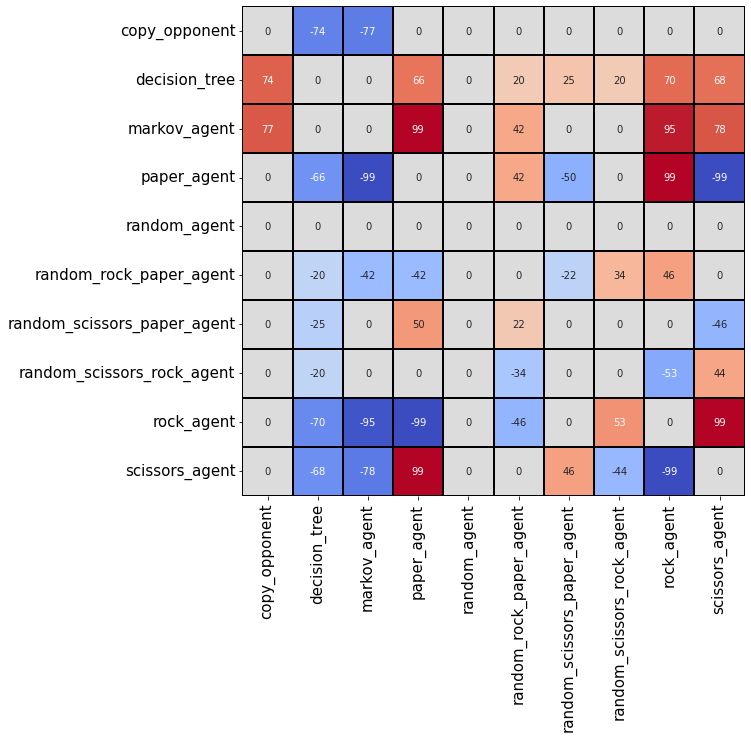

In [ ]:
df_scores = pd.DataFrame(
    scores, 
    index=list_names, 
    columns=list_names,
)


plt.figure(figsize=(9, 9))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap='coolwarm', linewidths=1, 
    linecolor='black', fmt="d",
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);

По результатам турнира можно утверждать что ни одна стратегия не превосходит рандомного агента. Из остальных агентов хорошо себя показывает Марков агент.